# 12.1. A/B Testing

- A/B testing: In data analytics, deciding whether two numerical samples come from the same underlying distribution is called A/B testing.

## 12.1.1. Smokers and Nonsmokers
- births: **1,174** mother-baby pairs
- Goal: Is mother smoking associated with baby weight?

In [1]:
##### headers
##### the data folder; note the relative path
path_data = "../../data/"

from datascience import *

In [2]:
##### load the data: births
births = Table.read_table(path_data + "baby.csv")
births.show(5)  ### take a look at the data

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False


In [3]:
##### tbl.select returns table => tbl.column creates arrays
### select outputs table; column ==> array
# # births.column('Maternal Smoker')

smoking_and_birthweight = births.select("Maternal Smoker", "Birth Weight")
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [4]:
##### group to count the number of smokers/non-smokers in dataset

smoking_and_birthweight.group("Maternal Smoker")

Maternal Smoker,count
False,715
True,459


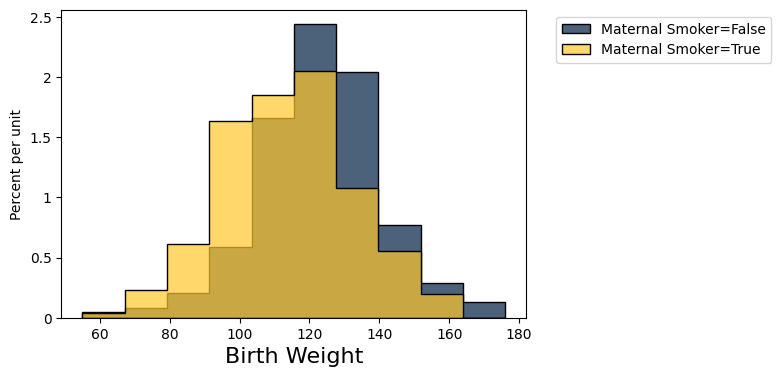

In [5]:
##### visualize it first
##### # births.column('Maternal Smoker')
##### can't find reference to this group argument anywhere

import matplotlib.pyplot as plots

%matplotlib inline
# plt.show()

smoking_and_birthweight.hist("Birth Weight", group="Maternal Smoker")
# smoking_and_birthweight.hist('Birth Weight', group = 'Maternal Smoker', bins=(100))

In [6]:
##### it looks slightly different
##### is the difference caused by the chance variation? Or by the population?

## 12.1.2. The Hypotheses

- **null hypothesis**: In this population, the **distribution** of birth weights of babies is the smae for mothers who don't smoke and as for mothers who do. The **difference** of birht weight between the samples is **due to chance**. 
- **alternative hypothesis**: In the population, the babies of the mothers who smoke have a lower birth weight, **on average**, than the babies of the non-smoking mothers. 


## 12.1.3. Test Statistic

- The alternative hypothesis **compares the average birth weights of the two groups** and says that the average for the mothers who smoke is smaller. Therefore it is reasonable for us to use the **difference** between the two **group means** as our statistic.

In [7]:
import numpy as np

##### what's the average weight?
# type(np.mean(births.column('Birth Weight')))
num = np.mean(births.column("Birth Weight"))
# round(num, 2)

### format string
float("{:,.2f}".format(num))
### f-string
# num = f"{num:.2f}"
# num
# float(num)

119.46

In [8]:
import numpy as np

##### use the same table, which has weight info, do an average instead of count,
##### then with group, we'll have average from both groups

means_table = smoking_and_birthweight.group(
    "Maternal Smoker", np.average
)  ### use function
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [9]:
##### use column and item to get the difference between the two groups
##### this is a technique based on your understanding of table/column/cell access

means = means_table.column(1)  ### this is an array
# means
observed_difference = means.item(1) - means.item(0)
observed_difference

##### not simulated
##### we got this number that is the mean difference of a variable based on smoke-grouping ==> birth-weight

-9.266142572024918

In [10]:
### funciton: Variable X and Birth-Weigth
### why are we not comparing smoker vs all? the guess is that somker < non-smoker and the
### difference would be larger than smoker - average


def difference_of_means(table, group_label):
    reduced = table.select("Birth Weight", group_label)   ### select two columns and returns table
    means_table = reduced.group(group_label, np.average)  ### column/array: average weight
    means = means_table.column(1)  ### average weight column
    return means.item(1) - means.item(0)  
    ### difference between the group means (smoker vs non-smoker)
    # return means[1] - means[0]            ### you don't have to use item().

In [11]:
difference_of_means(births, "Maternal Smoker")

-9.266142572024918

## 12.1.4. Predicting the Statistic Under the Null Hypothesis

- To see how the statistic should vary under the null hypothesis, we have to figure out how to simulate the statistic under that hypothesis.
- A clever method based on random permutations does just that.
- **Random permutation**: to shuffle all the labels randomly among the mothers. This is called random permutation.
- Then, let's compare the **means** of the two groups.

In [12]:
smoking_and_birthweight.show(3)

Maternal Smoker,Birth Weight
False,120
False,113
True,128


In [13]:
##### use sample() to shuffle
##### sample() will take everyone
##### place the column to the table

shuffled_labels = smoking_and_birthweight.sample(with_replacement=False).column(
    0
)  ### a shuffled column
original_and_shuffled = smoking_and_birthweight.with_column(
    "Shuffled Label", shuffled_labels
)

In [14]:
original_and_shuffled.show(5)

Maternal Smoker,Birth Weight,Shuffled Label
False,120,False
False,113,True
True,128,True
True,108,False
False,136,False


In [15]:
##### check the average weights in the two groups
shuffled_only = original_and_shuffled.select("Birth Weight", "Shuffled Label")
shuffled_group_means = shuffled_only.group(
    "Shuffled Label", np.average
)  ### group means!!!!!
shuffled_group_means

Shuffled Label,Birth Weight average
False,120
True,118.625


In [16]:
### finding the differences of the shuffled
difference_of_means(original_and_shuffled, "Shuffled Label")

-1.3747276688453098

In [17]:
difference_of_means(original_and_shuffled, "Maternal Smoker")  ### we have this

-9.266142572024918

In [18]:
### get the variability between the gorups means
### let's use the original table 'births'


def one_simulated_difference_of_means():
    ##### array of shuffled lables
    ##### this is the random part
    shuffled_labels = births.sample(with_replacement=False).column("Maternal Smoker")

    ### table of birth weights and shuffled labels
    ### the logic should be 1) create columns; 2_ add columns together
    shuffled_table = births.select("Birth Weight").with_column(
        "Shuffled Label", shuffled_labels
    )

    ### send the args to function
    return difference_of_means(shuffled_table, "Shuffled Label")

In [19]:
one_simulated_difference_of_means()

-1.7646479881774013

## 12.1.5. Permutation Test

- https://en.wikipedia.org/wiki/Permutation_test
- A permutation test (also called re-randomization test or shuffle test) is an exact statistical hypothesis test making use of the proof by contradiction. A permutation test involves two or more samples. The null hypothesis is that all samples come from the same distribution H0: F = G. Under the null hypothesis, the distribution of the test statistic is obtained by calculating all possible values of the test statistic under possible rearrangements of the observed data. Permutation tests are, therefore, a form of resampling.

In [20]:
### simulate our test statistic – the difference between the average birth
### weight of the two randomly formed groups

differences = make_array()
repetitions = 1000

for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    differences = np.append(differences, new_difference)

In [21]:
# differences

## 12.1.6. Conclusion of the Test

Observed Difference: -9.266142572024918


Text(0.5, 1.0, 'Prediction Under the Null Hypothesis')

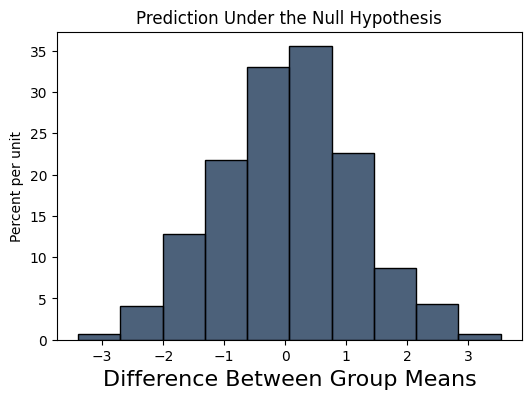

In [22]:
### create a table for visualization
Table().with_column("Difference Between Group Means", differences).hist()
print("Observed Difference:", observed_difference)
plots.title("Prediction Under the Null Hypothesis")

In [23]:
np.count_nonzero(differences <= observed_difference)

0

In [24]:
##### Conclusion: The data favor the alternative over the null.
##### p-value

empirical_p = np.count_nonzero(differences <= observed_difference) / repetitions
empirical_p

0.0

## 12.1.7. Another Permutation Test

- Compare other attributes: how about smoker x age
- Are smokers younger than non-smokers?

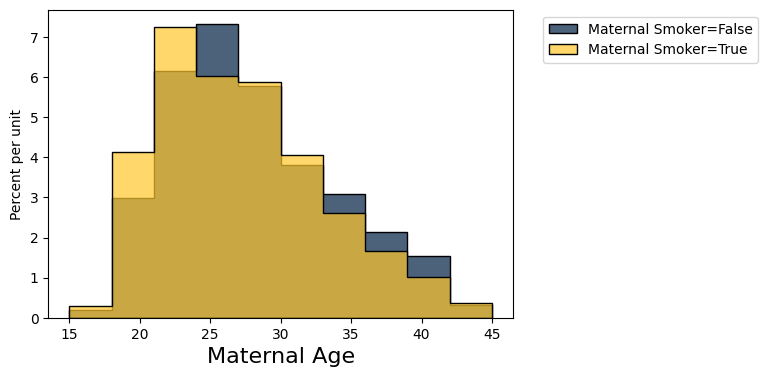

In [25]:
smoking_and_age = births.select("Maternal Smoker", "Maternal Age")  ### get the new table
# smoking_and_age.show(5)
smoking_and_age.hist("Maternal Age", group="Maternal Smoker")
##### smokers seem to be younger?

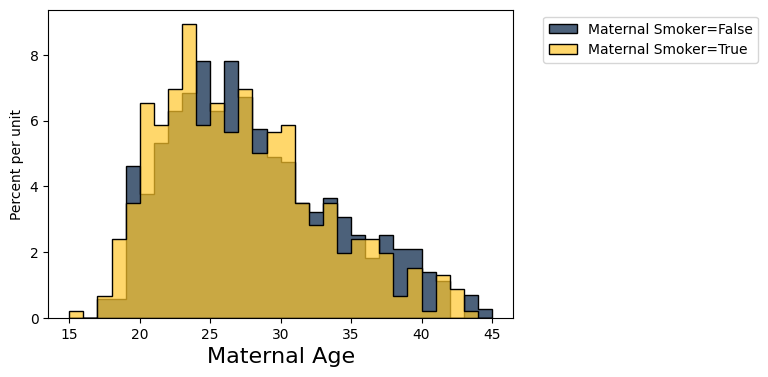

In [26]:
smoking_and_age.hist("Maternal Age", group="Maternal Smoker", bins=30)

In [34]:
##### badly designed function: do not hard-code "Maternal Age"
##### this function is for age...


def difference_of_means(table, group_label):
    """Takes: 
    table: name of table,
    group_label: column label that indicates the group to which the row belongs
    Returns: Difference of mean ages of the two groups"""
    reduced = table.select("Maternal Age", group_label)  ### select the two columns (age, smoke) ==> table
    means_table = reduced.group(group_label, np.average) ### group by label & average the age
    means = means_table.column(1)         ### select the column/array (age averages of two groups)
    return means.item(1) - means.item(0)  ### calculate the difference between smoke & none

In [35]:
observed_age_difference = difference_of_means(births, "Maternal Smoker")
observed_age_difference

### the difference is calculated as the mean age of the smokers minus the mean age of the non-smokers.

-0.8076725017901509

In [37]:
##### simulation: instead of usign the MS T/F labels, use shuffled labels!!!!!!!!


def one_simulated_difference_of_means():
    
    # array of shuffled labels
    shuffled_labels = births.sample(with_replacement=False).column("Maternal Smoker")
    
    # table of ages and shuffled lables
    shuffled_table = births.select("Maternal Age").with_column("Shuffled Label", shuffled_labels)
    
    return difference_of_means(shuffled_table, "Shuffled Label")


# def one_simulated_difference_of_means():
#     """Returns: Difference between mean ages
#     of smokers and non-smokers after shuffling labels"""

#     # array of shuffled labels
#     shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')

#     # table of ages and shuffled labels
#     shuffled_table = births.select('Maternal Age').with_column(
#         'Shuffled Label', shuffled_labels)

#     return difference_of_means(shuffled_table, 'Shuffled Label')

In [38]:
age_differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    age_differences = np.append(age_differences, new_difference)

# age_differences = make_array()

# repetitions = 5000
# for i in np.arange(repetitions):
#     new_difference = one_simulated_difference_of_means()
#     age_differences = np.append(age_differences, new_difference)

In [39]:
age_differences

array([ 1.00599357, -0.2210034 ,  0.15460792, ..., -0.05644987,
        0.24046193, -0.07075887])

Observed Difference: -0.8076725017901509


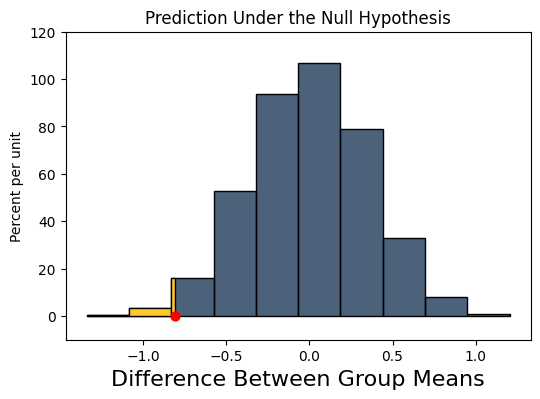

In [48]:
Table().with_column("Difference Between Group Means", age_differences).hist(
    right_end = observed_age_difference)

plots.ylim(-0.1, 1.2)
plots.scatter(observed_age_difference, 0, color="red", s=40, zorder=3)
plots.title("Prediction Under the Null Hypothesis")
print("Observed Difference:", observed_age_difference)

In [49]:
##### p-value
empirical_p = np.count_nonzero(age_differences <= observed_age_difference) / 5000
empirical_p

0.0116

The empirical p-value is around 1% and therefore the result is statistically significant. The test supports the hypothesis that the smokers were younger on average.